In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import seaborn as sns
import pickle
import pandas as pd 
from scipy.interpolate import interp1d


with open('data_behaviour.pkl', 'rb') as fp:
    data_behaviour = pickle.load(fp)


time_pre = 1
time_post = 1.5
nb_resample_points = 100
resample_time = np.linspace(-time_pre,time_post,nb_resample_points)

In [76]:
def format_data_psth(session_uid,plot_sessions=False,gain_change_sample=None):

    running_speed = data_behaviour[session_uid]['running_speed']
    running_speed[running_speed < -25] = None
    gain = data_behaviour[session_uid]['gain']
    trial_num = data_behaviour[session_uid]['trial_num']
    wheel_position = data_behaviour[session_uid]['wheel_position']
    df_over_f =data_behaviour[session_uid]['df_over_f']
    sample_times = data_behaviour[session_uid]['sample_times']
    absolute_speed = running_speed / gain

    if gain_change_sample == 'RL2_gain' :
        gain_change_samples = np.where(np.abs(np.diff(gain)) > 0.01)[0][:-1]
        print(gain_change_samples)
    elif gain_change_sample == 'RL2_phase' :
        gain_change_samples = np.where(np.abs(np.diff(wheel_position)) > 100)[0][:-1]
        print(gain_change_samples)
    else :
        gain_change_samples = np.where(np.diff(trial_num) > 0)[0]
    gain_change_magnitudes = [np.diff(gain)[ix] for ix in gain_change_samples]
    gain_pre = gain[gain_change_samples]
    gain_post = gain[gain_change_samples + 1]
    print("number of gain change events",gain_pre.shape[0])
    trial_number = trial_num[gain_change_samples]
    sinusoid_frequency = 50 / 3  # from Romain
    delta_position = np.mod(np.diff(wheel_position)[gain_change_samples], sinusoid_frequency)
    glitch_limits = (sinusoid_frequency * 0.2, sinusoid_frequency * 0.8)

    dt = np.median(np.diff(sample_times))
    samples_pre = np.round(time_pre / dt).astype(int)
    samples_post = np.round(time_post / dt).astype(int)
    print("sampling frequency",dt)

    gain_change_psth = []
    n_samples = len(df_over_f)

    # we need to rewrite this to resample the signal using interpolation.
    interp = interp1d(sample_times,df_over_f,fill_value="extrapolate")
    resample_df_over_f = interp(resample_time)


    for sample in gain_change_samples:
        trial_trace = df_over_f[(sample - samples_pre) : (sample + samples_post)]
        if sample + samples_post - n_samples > 0:
            trial_trace = np.concatenate(
                (trial_trace, np.full(sample + samples_post - n_samples, np.nan))
            )
        trial_time = np.linspace(-time_pre,time_post,samples_pre+samples_post)
        interp = interp1d(trial_time,trial_trace,fill_value="extrapolate")
        resample_df_over_f = interp(resample_time)
        gain_change_psth.append(resample_df_over_f[:, np.newaxis])
        

    gain_change_psth =  np.concatenate(gain_change_psth, axis=1).T
    print(gain_change_psth.shape)
    gain_change_df = pd.DataFrame(gain_change_psth)
    gain_change_df["gain_change_magnitude"] = gain_change_magnitudes
    gain_change_df["phase_shift"] = delta_position
    gain_change_df["gain_pre"] = gain_pre
    gain_change_df["gain_post"] = gain_post
    gain_change_df['trial_number'] = trial_number
    gain_change_df = gain_change_df.melt(
                    id_vars=[
                    "gain_change_magnitude",
                    "phase_shift",
                    "gain_pre",
                    "gain_post",
                    "trial_number"]).rename(columns={"variable": "time", "value": "dF/F"})
    gain_change_df['phase_shift_approx'] = "other"
    gain_change_df.loc[
        (gain_change_df["phase_shift"] <= glitch_limits[0])
        | (gain_change_df["phase_shift"] >= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to 0"
    gain_change_df.loc[
        (gain_change_df["phase_shift"] >= glitch_limits[0])
        & (gain_change_df["phase_shift"] <= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to pi"

    gain_change_psth_speed = []
    for sample in gain_change_samples:
        trial_trace = absolute_speed[(sample - samples_pre) : (sample + samples_post)]
        if sample + samples_post - n_samples > 0:
            padded_trace = np.concatenate(
                (trial_trace, np.full(sample + samples_post - n_samples, np.nan))
            )
        trial_time = np.linspace(-time_pre,time_post,samples_pre+samples_post)
        interp = interp1d(trial_time,trial_trace,fill_value="extrapolate")
        resample_df_over_f = interp(resample_time)
        gain_change_psth_speed.append(resample_df_over_f[:, np.newaxis])

    gain_change_psth_speed =  np.concatenate(gain_change_psth_speed, axis=1).T
    gain_change_df_speed = pd.DataFrame(gain_change_psth_speed)
    gain_change_df_speed["gain_change_magnitude"] = gain_change_magnitudes
    gain_change_df_speed["phase_shift"] = delta_position
    gain_change_df_speed["gain_pre"] = gain_pre
    gain_change_df_speed["gain_post"] = gain_post
    gain_change_df_speed['trial_number'] = trial_number
    gain_change_df_speed = gain_change_df_speed.melt(
                    id_vars=[
                    "gain_change_magnitude",
                    "phase_shift",
                    "gain_pre",
                    "gain_post",
                    "trial_number"]).rename(columns={"variable": "time", "value": "speed"})
    gain_change_df_speed['phase_shift_approx'] = "other"
    gain_change_df_speed.loc[
        (gain_change_df_speed["phase_shift"] <= glitch_limits[0])
        | (gain_change_df_speed["phase_shift"] >= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to 0"
    gain_change_df_speed.loc[
        (gain_change_df_speed["phase_shift"] >= glitch_limits[0])
        & (gain_change_df_speed["phase_shift"] <= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to pi"

    if plot_sessions : 
        i_start=5000
        i_end= 25000
        plt.figure(figsize=(20,20))
        plt.subplot(611)
        plt.plot(running_speed[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('running speed')
        plt.subplot(612)
        plt.plot(gain[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('gain')
        plt.subplot(613)
        plt.plot(trial_num[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('trial_num')
        plt.subplot(614)
        plt.plot(wheel_position[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('wheel_position')
        plt.subplot(615)
        plt.plot(df_over_f[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('df_over_f')
        plt.subplot(616)
        plt.plot(absolute_speed[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('absolute speed')
        plt.show()


    gain_change_df['uid'] = session_uid
    gain_change_df['speed'] = gain_change_df_speed['speed']

    return gain_change_df

In [70]:
sessions_uid = list(data_behaviour.keys())
sessions_uid.remove('RL1_3_3')
sessions_uid.remove('RL2_1_0')
sessions_uid.remove('RL2_5_0') # bad

sessions_uid = ['RL1_1_0',
                'RL1_1_1',
                'RL1_1_2',
                'RL1_1_3',
                'RL1_1_4',
                'RL1_4_0',
                'RL1_4_1',
                'RL1_4_2',
                'RL1_5_0',
                'RL1_5_1',
                'RL1_5_2',
                'RL1_5_3',
                'RL1_5_4']

In [71]:
list(data_behaviour.keys())

['RL1_1_0',
 'RL1_1_1',
 'RL1_1_2',
 'RL1_1_3',
 'RL1_1_4',
 'RL2_1_0',
 'RL1_2_0',
 'RL1_2_1',
 'RL1_2_2',
 'RL1_3_0',
 'RL1_3_1',
 'RL1_3_2',
 'RL1_3_3',
 'RL1_4_0',
 'RL1_4_1',
 'RL1_4_2',
 'RL1_5_0',
 'RL1_5_1',
 'RL1_5_2',
 'RL1_5_3',
 'RL1_5_4',
 'RL2_5_0']

In [72]:
list_df_data = []
for uid in sessions_uid :
    print(uid)
    gain_change_df = format_data_psth(uid,plot_sessions=False)
    list_df_data.append(gain_change_df)
gain_change_df = pd.concat(list_df_data)

gain_change_df = gain_change_df.dropna()
dict_map_mag = {-2.7 : "--", -2 : '-',-0.7:'-',0:'0',0.7 : '+',2.7 : "++", 2 : '+'}
gain_change_df['gain_change'] = gain_change_df['gain_change_magnitude'] 
gain_change_df = gain_change_df.replace({"gain_change_magnitude": dict_map_mag})

RL1_1_0
number of gain change events 13
sampling frequency 0.033343999999488005
(13, 100)
RL1_1_1
number of gain change events 24
sampling frequency 0.03334399999585003
(24, 100)
RL1_1_2
number of gain change events 18
sampling frequency 0.033343999999488005
(18, 100)
RL1_1_3
number of gain change events 14
sampling frequency 0.03334399999585003
(14, 100)
RL1_1_4
number of gain change events 23
sampling frequency 0.033343999999488005
(23, 100)
RL1_4_0
number of gain change events 17
sampling frequency 0.033343999999488005
(17, 100)
RL1_4_1
number of gain change events 10
sampling frequency 0.03334399999585003
(10, 100)
RL1_4_2
number of gain change events 12
sampling frequency 0.033343999999488005
(12, 100)
RL1_5_0
number of gain change events 19
sampling frequency 0.033343999999488005
(19, 100)
RL1_5_1
number of gain change events 24
sampling frequency 0.03334399999585003
(24, 100)
RL1_5_2
number of gain change events 31
sampling frequency 0.033343999999488005
(31, 100)
RL1_5_3
number

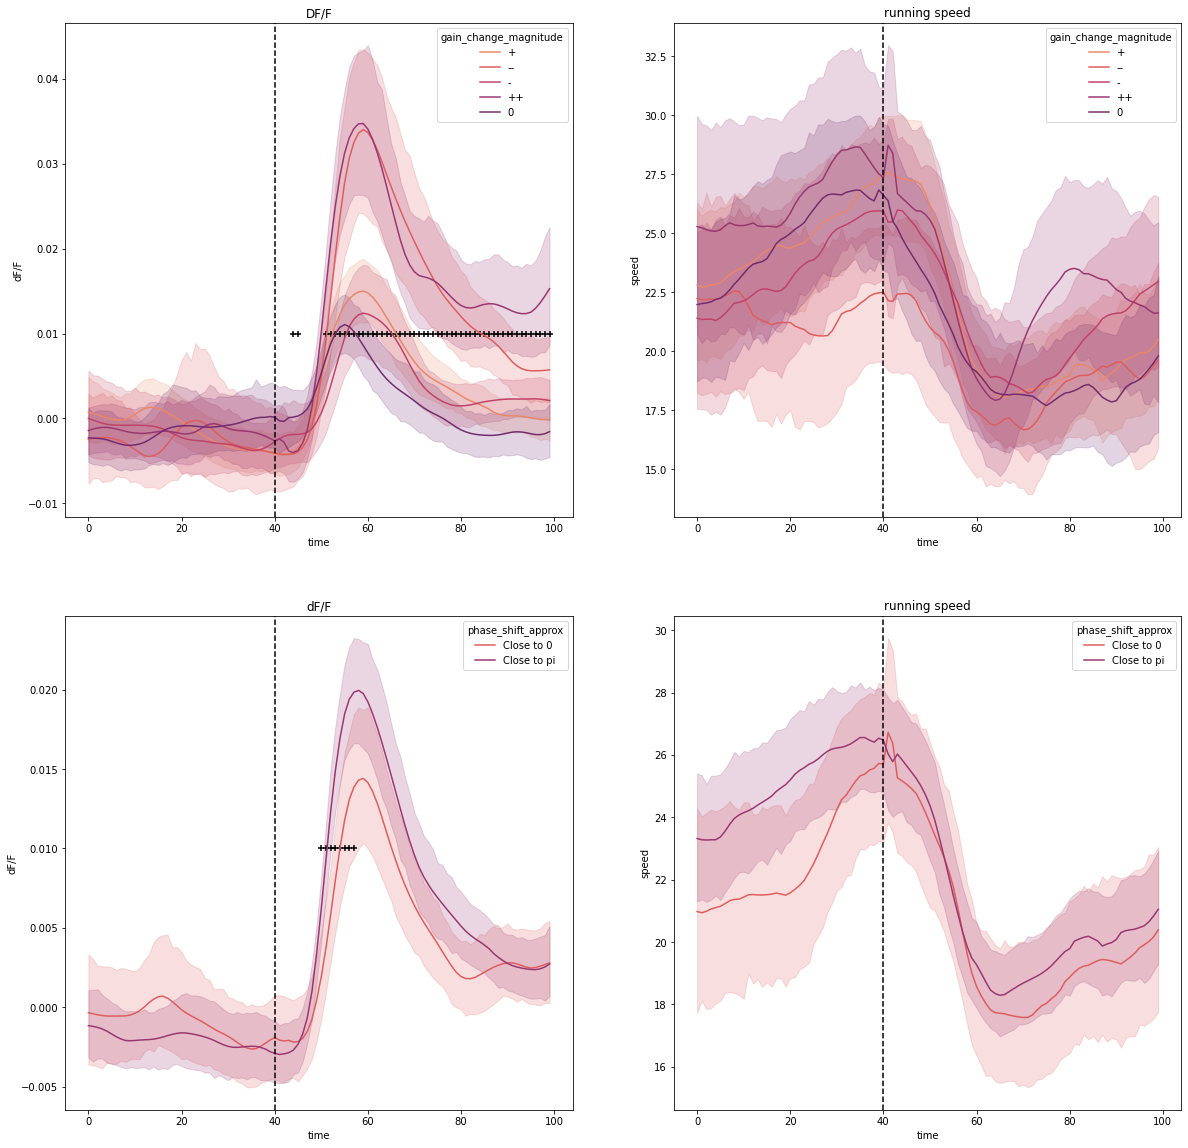

In [73]:
plt.figure(figsize=(20,20))


p_norm = 0.05

plt.subplot(221)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('DF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')


p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(['--','++']))]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(["0"]))]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")



plt.subplot(222)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')



plt.subplot(223)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='phase_shift_approx',
    palette="flare",
).set_title('dF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to 0")]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to pi")]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")

plt.subplot(224)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='phase_shift_approx',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

plt.show()

### Analysis for RL2 (bad experimental design)

RL2_1_0
[ 1886  3220  3425  8961 10365 10646 12024 36613 36916 46538 47747 48365
 66201 68150 69033 78533]
number of gain change events 16
sampling frequency 0.03334399964660406
(16, 100)


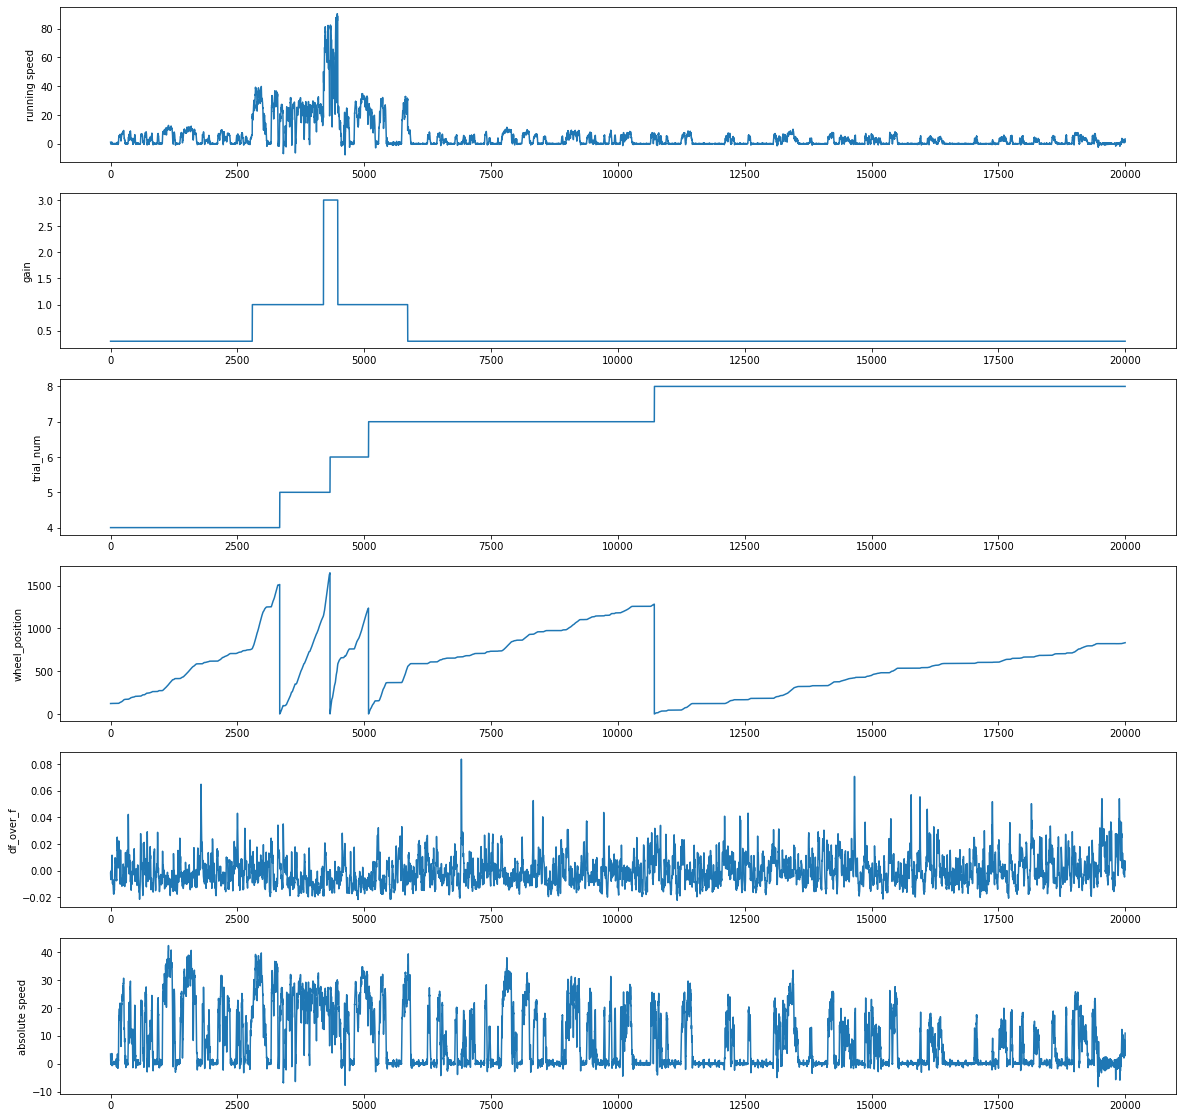

RL2_5_0
[  966  3248  3974  4458  7456  7598  8703 10725 11490 11710 12364 17924
 18875 22892 23325 25638 26372 30260 30550 35606 35887 37513 43547 43762
 47882 48286 51589 51764 52930 58273 61594 61914 67767 67930 69199 69722
 74806 75051]
number of gain change events 38
sampling frequency 0.03334399964660406
(38, 100)


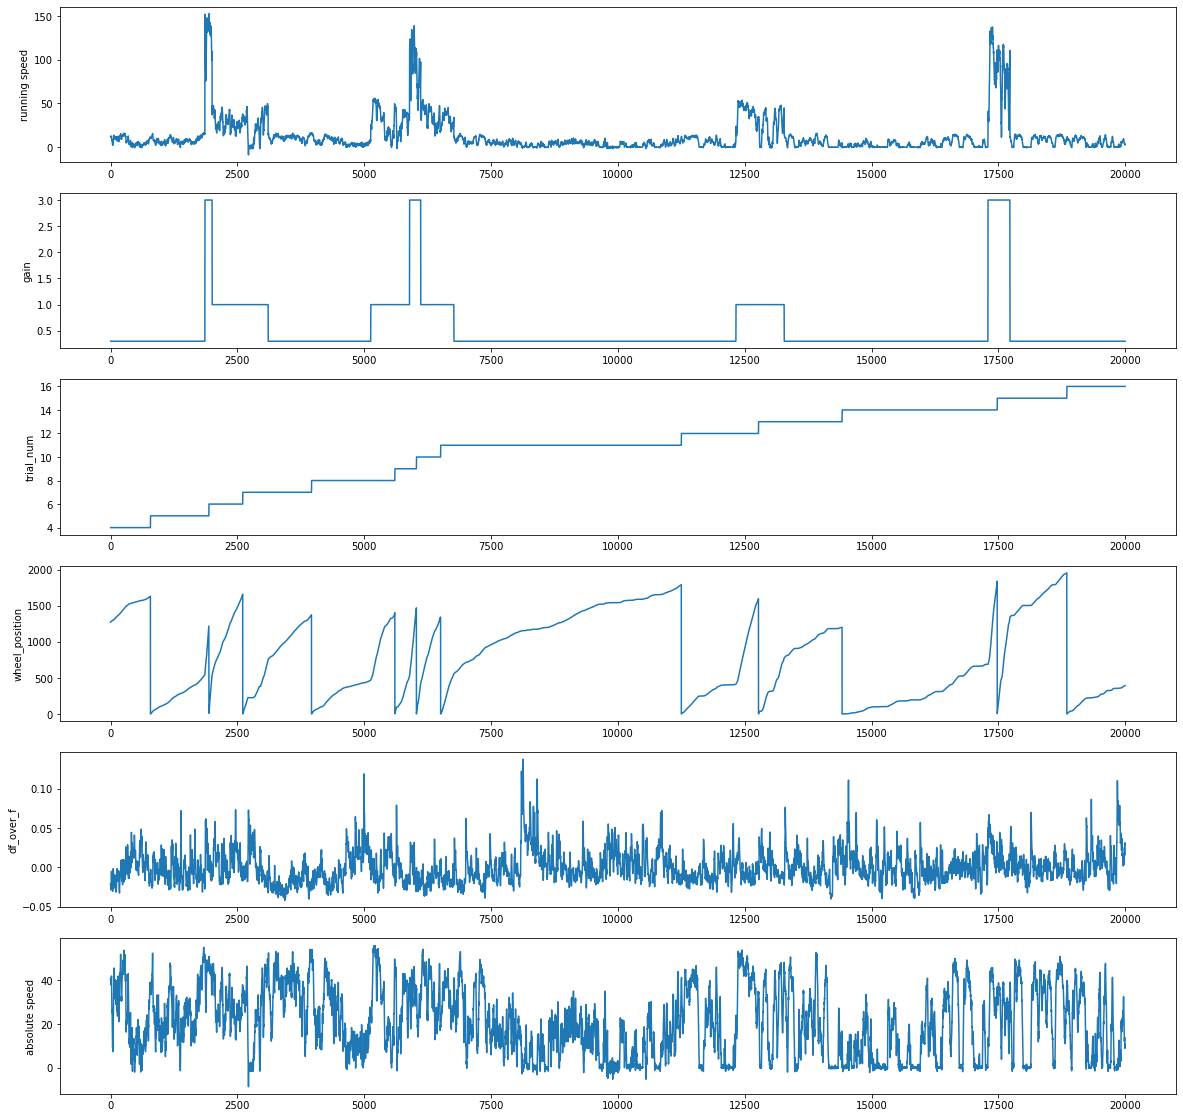

In [83]:
sessions_uid = ['RL2_1_0','RL2_5_0']

list_df_data = []
for uid in sessions_uid :
    print(uid)
    gain_change_df = format_data_psth(uid,plot_sessions=True,gain_change_sample="RL2_gain")
    list_df_data.append(gain_change_df)

gain_change_df = pd.concat(list_df_data)
gain_change_df = gain_change_df.dropna()
dict_map_mag = {-2.7 : "--", -2 : '-',-0.7:'-',0:'0',0.7 : '+',2.7 : "++", 2 : '+'}
gain_change_df['gain_change'] = gain_change_df['gain_change_magnitude'] 
gain_change_df = gain_change_df.replace({"gain_change_magnitude": dict_map_mag})

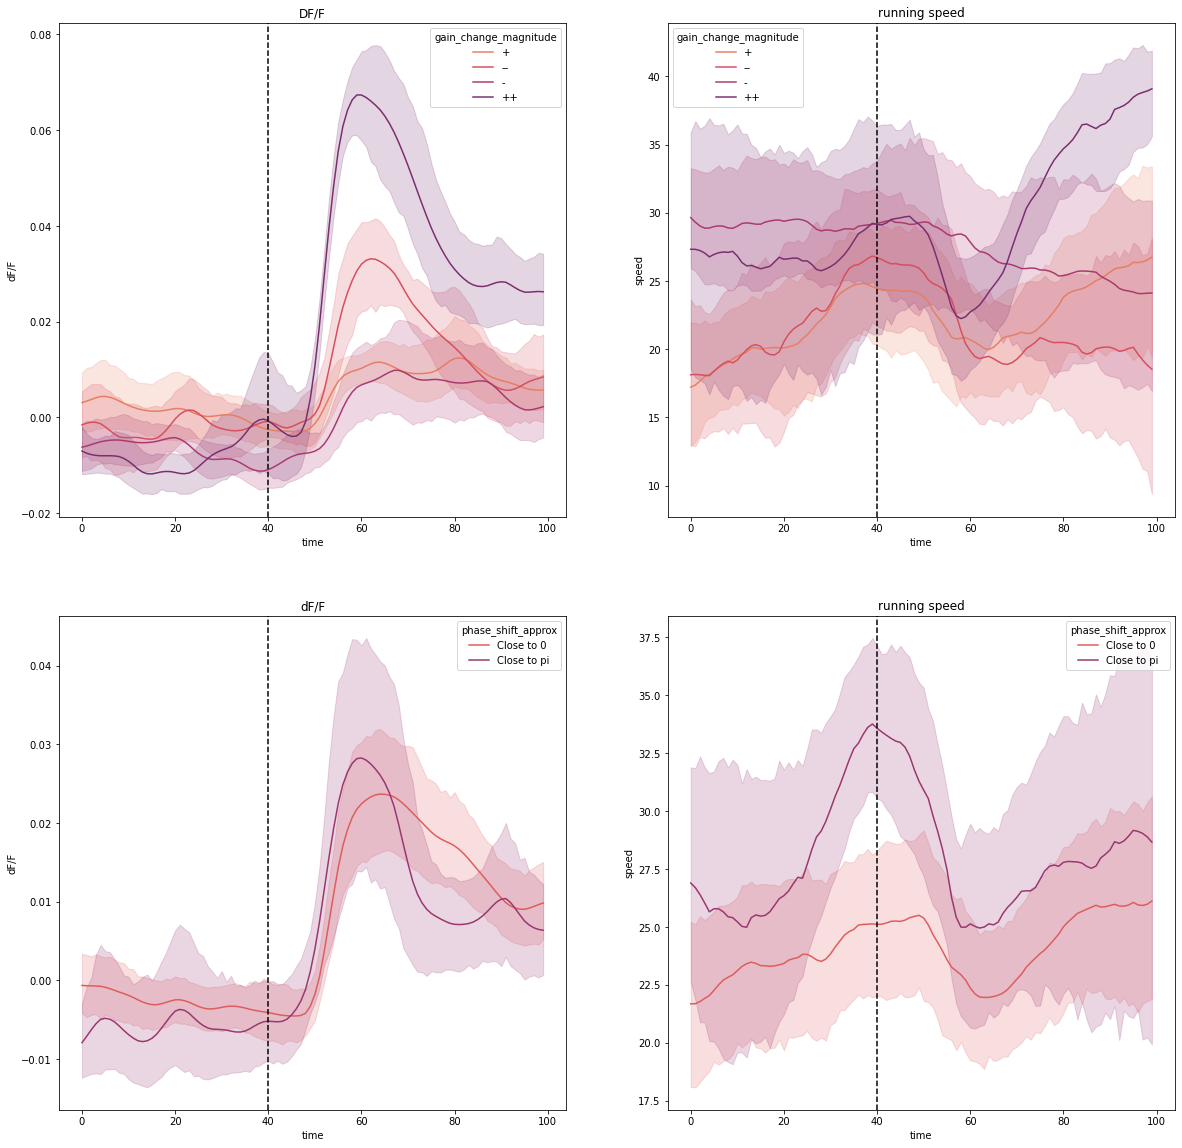

In [82]:
plt.figure(figsize=(20,20))


p_norm = 0.05

plt.subplot(221)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('DF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')


p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(['--','++']))]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(["0"]))]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")



plt.subplot(222)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')



plt.subplot(223)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='phase_shift_approx',
    palette="flare",
).set_title('dF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to 0")]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to pi")]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")

plt.subplot(224)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='phase_shift_approx',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

plt.show()